In [27]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import pickle
from lib import read_file,gateset_string,level_spacing,bipartite_split,coolable

# mpl cosmetics
import matplotlib as mpl
from matplotlib.lines import lineMarkers
from matplotlib.colors import BASE_COLORS
import matplotlib.patches as mpatches
lineMarkers = tuple(lineMarkers.keys())
baseColors = tuple(BASE_COLORS.keys())

In [28]:
# reading the data from the pickled file
therm_data_CNOT = ()
therm_data_iSWAP = ()
beta_data = ()

# thermalization for different gate sets
therm_data_CNOT += read_file("data/07-02_22-30-12___data.pickle") # (CNOT,H,Z)
therm_data_CNOT += read_file("data/07-02_19-40-49___data.pickle") # (CNOT,H,X)
therm_data_CNOT += read_file("data/07-02_19-40-58___data.pickle") # (CNOT,H,S)
therm_data_CNOT += read_file("data/07-02_19-41-03___data.pickle") # (CNOT,H,T)

therm_data_iSWAP += read_file("data/07-02_22-33-37___data.pickle")

# thermalization for different (inverse) temperatures beta
beta_data += read_file("data/07-02_19-44-30___data.pickle")

File data/07-02_22-30-12___data.pickle is over.
File data/07-02_19-40-49___data.pickle is over.
File data/07-02_19-40-58___data.pickle is over.
File data/07-02_19-41-03___data.pickle is over.
File data/07-02_22-33-37___data.pickle is over.
File data/07-02_19-44-30___data.pickle is over.


In [46]:
def thermalization_timeline_plot(datasets:tuple[dict],var_shades:bool=False,fname:str="",savefig:bool=False):
    """
    Plots thermalization (heating and cooling) for all simulation data in `datasets`. Separate plots are created
    for every gate set, and saved under `writing/plots/`. If `var_shaedes`, the standard deviation in mean entropy
    is included as a shaded region.
    """
    # finding the gate for which we have simulation data
    gate_sets = ()
    for dataset in datasets:
        if dataset["gate_set"] not in gate_sets: gate_sets += (dataset["gate_set"],)

    # plotting
    for gate_set in gate_sets:
        fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,4))
        for dataset in datasets:
            if dataset["gate_set"] == gate_set:
                step_axis = np.arange(dataset["heating"]["nSteps"]+dataset["cooling"]["nSteps"]+2)
                Svn = np.concatenate((dataset["Svn_heating"].mean(axis=(2,)),dataset["Svn_cooling"].mean(axis=(2,))),axis=1)
                ax.plot(step_axis,Svn.mean(axis=(0,)),label="N = {}".format(dataset["heating"]["nWires"]))
                if var_shades:
                    Svn_std = np.std(Svn,axis=(0,))
                    ax.fill_between(step_axis,Svn.mean(axis=(0,))-Svn_std,Svn.mean(axis=(0,))-Svn_std,label="N = {}".format(dataset["heating"]["nWires"]))
        ax.set_xlabel("#step")
        ax.set_xscale("log")
        ax.set_title("gate set " + gateset_string(gate_set))
        ax.set_ylabel(r"$\langle S_{N_A}\rangle$")
        ax.legend(loc="upper left")
    
        if savefig:
            fig.savefig("writing/plots/therm_" + gateset_string(gate_set) + fname + ".pdf",bbox_inches="tight")

def beta_plot(datasets:tuple[dict],fname:str="",savefig:bool=False):
    """
    Plots the cooling process for every value of beta, where beta is included as a colormap. A separate plot is created for
    every gate set, for which there is simulation data present in `datasets`. Plots are saved under `writing/plots/`.
    """
    # finding the gates and betas for which we have simulation data
    gate_sets = ()
    beta_axis = ()
    for dataset in datasets:
        if dataset["gate_set"] not in gate_sets: gate_sets += (dataset["gate_set"],)
        if dataset["cooling"]["beta"] not in beta_axis: beta_axis += (dataset["cooling"]["beta"],)

    cmap = mpl.colormaps["plasma"]

    for gate_set in gate_sets:
        fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,4))
        for dataset in datasets:
            if dataset["gate_set"] == gate_set:
                step_axis = np.arange(dataset["cooling"]["nSteps"]+1)
                ax.plot(
                    step_axis,
                    dataset["Svn_cooling"].mean(axis=(0,2)),
                    label=r"$\beta$ = {}".format(dataset["cooling"]["beta"]),
                    c=cmap((dataset["cooling"]["beta"] - min(beta_axis)) / (max(beta_axis) - min(beta_axis)))
                )
        ax.set_xlabel("#step")
        ax.set_xscale("log")
        ax.set_title("gate set " + gateset_string(gate_set))
        ax.set_ylabel(r"$\langle S_{N_A}\rangle$")
        fig.colorbar(plt.cm.ScalarMappable(mpl.colors.Normalize(vmin=min(beta_axis),vmax=max(beta_axis)),cmap="plasma"),ax=ax,label=r"$\beta$")

        if savefig:
            fig.savefig("writing/plots/betatest_" + gateset_string(gate_set) + fname + ".pdf",bbox_inches="tight")

def therm_speed_plot(datasets:tuple[dict],fname:str="",savefig:bool=False):
    """
    Plotting the cooling procedure for each gate set in `datasets` separately, where the number of wires in
    the system is color-coded in a colormap. One plot is created and saved under `writing/plots/`.
    """
    # starting value of mean entanglement entropy at the beginning of the cooling procedure, for each gate set, and number of Wires
    S0 = {}
    nWires_axis = ()
    for dataset in datasets:
        if dataset["gate_set"] not in S0.keys(): S0[dataset["gate_set"]] = {}
        # starting value of entanglement entropy
        S0[dataset["gate_set"]][dataset["heating"]["nWires"]] = dataset["Svn_cooling"].mean(axis=(0,2))[0]
        # number of wires
        if dataset["heating"]["nWires"] not in nWires_axis: nWires_axis += (dataset["heating"]["nWires"],)

    cmap = mpl.colormaps["plasma"]

    # ordering the gate sets according to which one reduces entanglement entropy by the largest amount
    deltaS = {}
    for dataset in datasets:
        if dataset["gate_set"] not in deltaS.keys(): deltaS[dataset["gate_set"]] = 0
        Sinit = dataset["Svn_cooling"].mean(axis=(0,2))[0]
        Slast = dataset["Svn_cooling"].mean(axis=(0,2))[-1]

        if Slast - Sinit < deltaS[dataset["gate_set"]]: deltaS[dataset["gate_set"]] = Slast - Sinit
    gate_sets_to_deltaS = [[gate_set for gate_set in deltaS.keys()],] + [[deltaS[gate_set] for gate_set in deltaS.keys()],]
    mask = np.argsort(gate_sets_to_deltaS[1])[::-1]

    # Offsets for every gate set, such that they start from different points on the y-axis and can be distinguished
    gate_set_offsets = {gate_sets_to_deltaS[0][iSet]:-i for i,iSet in enumerate(mask)}

    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,4))
    for dataset in datasets:
        step_axis = np.arange(dataset["cooling"]["nSteps"]+1)
        ax.plot(
            step_axis,
            dataset["Svn_cooling"].mean(axis=(0,2)) - S0[dataset["gate_set"]][dataset["heating"]["nWires"]] + gate_set_offsets[dataset["gate_set"]],
            label="N = {}".format(dataset["heating"]["nWires"]),
            c=cmap((dataset["heating"]["nWires"] - min(nWires_axis)) / (max(nWires_axis) - min(nWires_axis)))
        )
    ax.tick_params(axis="y",rotation=0,left=False,pad=-70)
    ax.set_xlabel("#step")
    ax.set_ylabel(r"$\langle S_{N_A}\rangle$")
    ax.set_yticks([gate_set_offsets[key]-0.3 for key in gate_set_offsets.keys()])
    ax.set_yticklabels([gateset_string(key) for key in gate_set_offsets.keys()])
    ax.set_xscale("log")
    # ax.legend()
    fig.colorbar(plt.cm.ScalarMappable(mpl.colors.Normalize(vmin=min(nWires_axis),vmax=max(nWires_axis)),cmap="plasma"),ax=ax,label=r"system size $N$")

    if savefig:
        fig.savefig("writing/plots/therm_speed" + fname + ".pdf",bbox_inches="tight")

def plot_level_spacing(
    datasets:tuple[dict],
    minval:float=0,
    cutoff:float=np.inf,
    nBins:int=100,
    fname:str="",
    fit:bool=False,
    savefig:bool=False,
):
    """
    Plots the distribution of consecutive singular value spacings for all simulation
    data in `datasets`. Datapoints are labelled by the corresponding gate set.

    All spacings smaller than `minval` will be dropped (introduced since values very close to zero
    typically have large counts).
    Only level spacings that are smaller than or equal to `cutoff` will be plotted in a linear plot,
    since this distribution tends to have a long tail. The tail is plotted logarithmically.
    """
    # finding the gate for which we have simulation data, and calculating the singular values
    singvals = {}
    for dataset in datasets:
        # bipartite split
        dataset_singvals = bipartite_split(dataset["psi_heating"])
        if dataset["gate_set"] not in singvals.keys():
            singvals[dataset["gate_set"]] = dataset_singvals
        else:
            singvals[dataset["gate_set"]] = np.concatenate((singvals[dataset["gate_set"]],dataset_singvals),axis=0)

    # calculating the spacings
    spacings_head = {}
    spacings_tail = {}
    nPoints = {}
    for gate_set in singvals.keys():
        spacings_gate_set = level_spacing(singvals[gate_set]).flatten()

        # dropping values smaller than minval
        spacings_gate_set = spacings_gate_set[spacings_gate_set >= minval]

        # dividing at cutoff into head and tail
        head_mask = spacings_gate_set <= cutoff
        tail_mask = spacings_gate_set > cutoff
        spacings_head[gate_set] = spacings_gate_set[head_mask] / np.mean(spacings_gate_set)
        spacings_tail[gate_set] = spacings_gate_set[tail_mask] / np.mean(spacings_gate_set)

        # saving the number of points for normalization
        nPoints[gate_set] = len(spacings_gate_set)

    # creating histograms
    hist_head = {}
    hist_tail = {}
    for gate_set in spacings_head.keys():
        counts,bins = np.histogram(spacings_head[gate_set],bins=nBins)
        hist_head[gate_set] = (bins[0] / 2 + bins[:-1],counts)
        counts,bins = np.histogram(spacings_tail[gate_set],bins=nBins)
        hist_tail[gate_set] = (bins[0] / 2 + bins[:-1],counts)

    def wigner_surmise(x,C,beta,A) -> float:
        return np.exp(-A * x**2) * C * x**beta

    def poisson(x,C,l) -> float:
        return C * sci.stats.poisson.pmf(x,l)
        return np.exp(-l) * l**x / sci.special.factorial(x,exact=False)

    if fit:
        # fitting functions to the spacing heads: The wigner surmise to the coolable gate sets, and the poisson distribution to the non-coolable gates
        coolable_bins = np.concatenate([hist_head[gate_set][0] for gate_set in hist_head.keys() if coolable[gate_set]])
        coolable_counts = np.concatenate([hist_head[gate_set][1] for gate_set in hist_head.keys() if coolable[gate_set]])
        non_coolable_bins = np.concatenate([hist_head[gate_set][0] for gate_set in hist_head.keys() if not coolable[gate_set]])
        non_coolable_counts = np.concatenate([hist_head[gate_set][1] for gate_set in hist_head.keys() if not coolable[gate_set]])

        # fitting to the wigner surmise
        coolable_popt,pcov = sci.optimize.curve_fit(wigner_surmise,coolable_bins,coolable_counts)
        coolable_fit = lambda x: wigner_surmise(x,coolable_popt[0],coolable_popt[1],coolable_popt[2])

        # fitting to the poisson distribution
        non_coolable_popt,pcov = sci.optimize.curve_fit(poisson,non_coolable_bins,non_coolable_counts)
        non_coolable_fit = lambda x: poisson(x,non_coolable_popt[0],non_coolable_popt[1])

    markers = {gate_set:lineMarkers[i] for i,gate_set in enumerate(spacings_head.keys())}
    colors = {gate_set:baseColors[1] if coolable[gate_set] else baseColors[0] for gate_set in spacings_head.keys()}

    # plotting the head
    fig_head,ax_head = plt.subplots(nrows=1,ncols=1)
    for gate_set in spacings_head.keys():
        ax_head.scatter(hist_head[gate_set][0],hist_head[gate_set][1],label=gateset_string(gate_set),marker=markers[gate_set],c=colors[gate_set],alpha=.5)

    if fit:
        bin_axis = np.linspace(start=coolable_bins.min(),stop=coolable_bins.max(),num=100)
        ax_head.plot(bin_axis,coolable_fit(bin_axis),label="Wigner surmise",linestyle="--",c=colors[gate_set])
        #ax_head.plot(bin_axis,non_coolable_fit(bin_axis),label="Poisson distribution")

    ax_head.set_xlabel(r"$\lambda_i-\lambda_{i+1} / \langle\lambda_i-\lambda_{i+1}\rangle$")
    ax_head.set_ylabel("counts")
    ax_head.legend()

    if savefig:
        fig_head.savefig("writing/plots/level_spacing_head" + fname + ".pdf",bbox_inches="tight")

    # plotting the tail
    fig_tail,ax_tail = plt.subplots(nrows=1,ncols=1)
    for gate_set in spacings_tail.keys():
        ax_tail.scatter(hist_tail[gate_set][0],hist_tail[gate_set][1],label=gateset_string(gate_set),marker=markers[gate_set],c=colors[gate_set],alpha=.5)
    ax_tail.set_xlabel(r"$\lambda_i-\lambda_{i+1} / \langle\lambda_i-\lambda_{i+1}\rangle$")
    ax_tail.set_ylabel("counts")
    ax_tail.legend()

    if savefig:
        fig_tail.savefig("writing/plots/level_spacing_tail" + fname + ".pdf",bbox_inches="tight")

def plot_max_heat(datasets:tuple[dict],fname:str="",savefig:bool=False):
    """
    Plots the maximum entanglement entropy for all simulation data in `datasets`. Separate plots are created
    for every gate set, and saved under `writing/plots/`.
    """
    # finding the gate for which we have simulation data
    gate_sets = ()
    for dataset in datasets:
        if dataset["gate_set"] not in gate_sets: gate_sets += (dataset["gate_set"],)

    # plotting
    for gate_set in gate_sets:
        fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(7,4))
        for dataset in datasets:
            if dataset["gate_set"] == gate_set:
                step_axis = np.arange(dataset["heating"]["nSteps"]+1)
                ax.plot(
                    step_axis,
                    dataset["Svn_heating"].mean(axis=(0)).max(axis=(1)),
                    label="N = {}".format(dataset["heating"]["nWires"]),
                )
                ax.axhline(dataset["heating"]["nWires"]/2,linestyle="--")
        ax.set_xlabel("#step")
        # ax.set_yscale("log")
        ax.set_title("gate set " + gateset_string(gate_set))
        ax.set_ylabel(r"$\max_{N_A}(S_{N_A})$")
        ax.legend(loc="upper left")
    
        if savefig:
            fig.savefig("writing/plots/maxheat_" + gateset_string(gate_set) + fname + ".pdf",bbox_inches="tight")


# Plots for thermalization

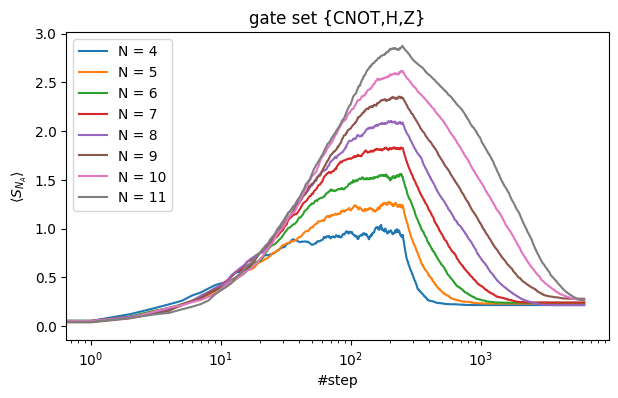

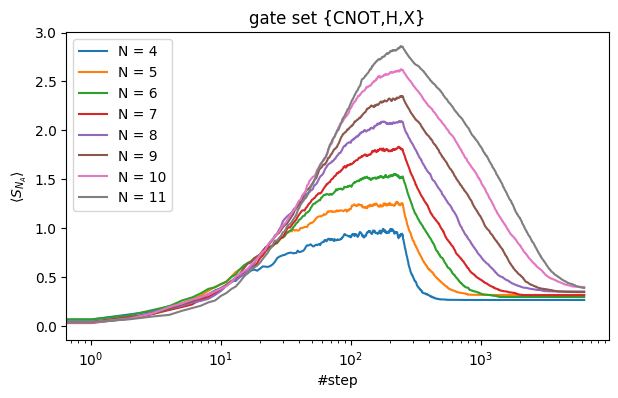

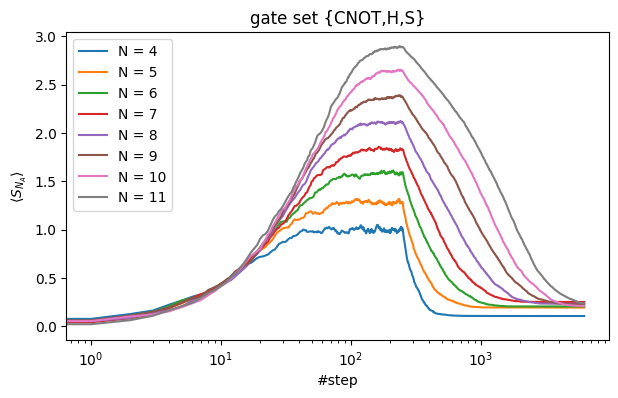

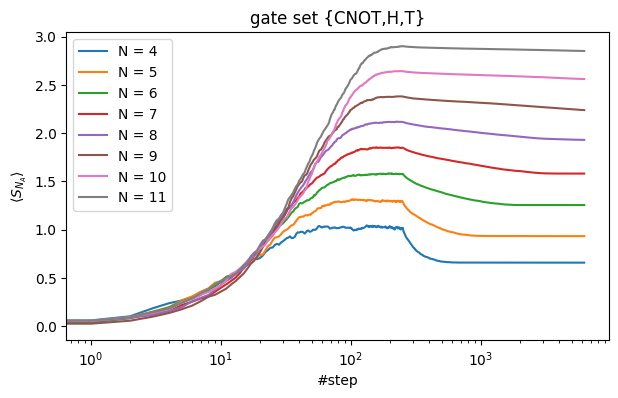

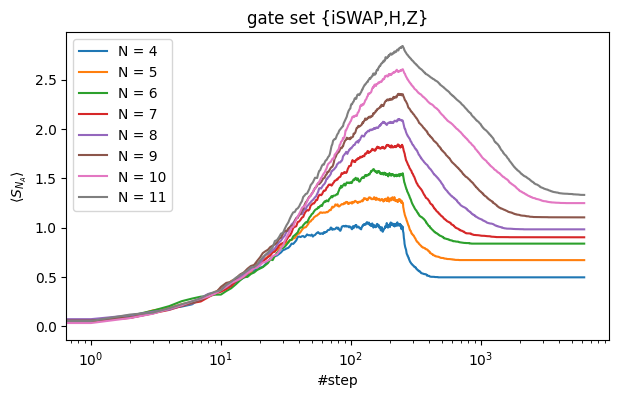

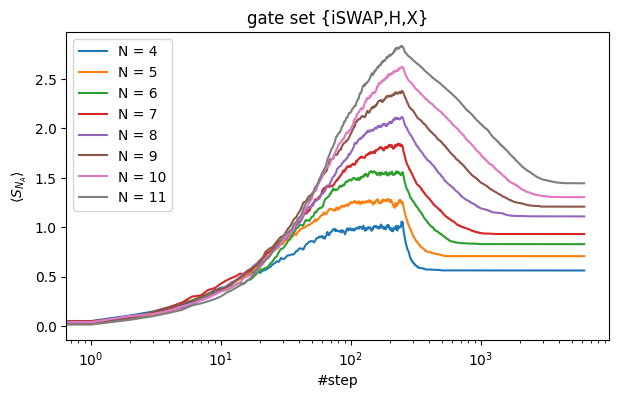

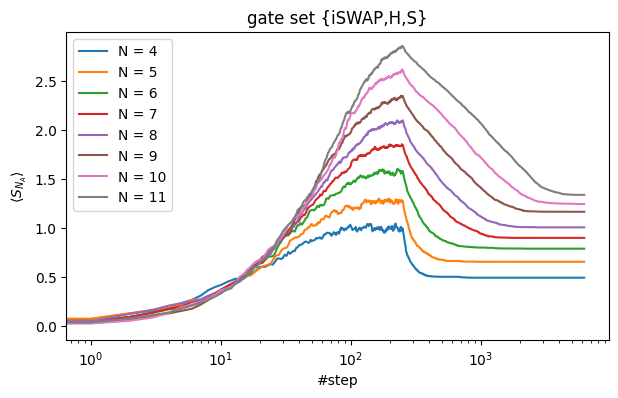

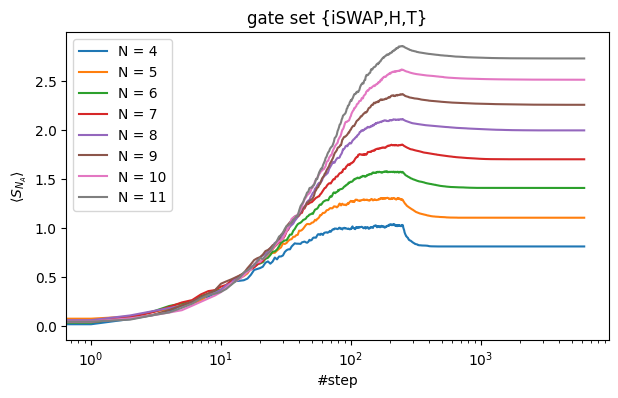

In [44]:
thermalization_timeline_plot(therm_data_CNOT,var_shades=False,savefig=True)
thermalization_timeline_plot(therm_data_iSWAP,savefig=True)

# Plots for different temperatures $\beta$

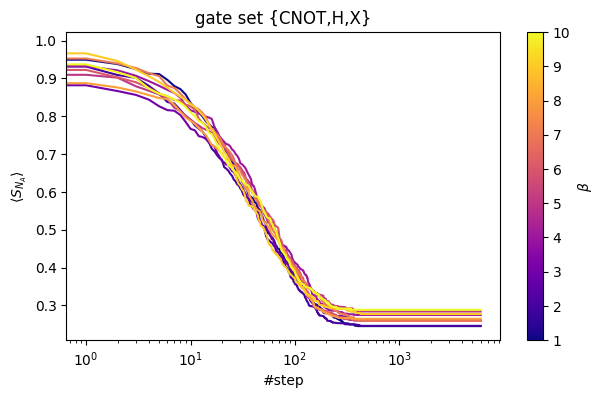

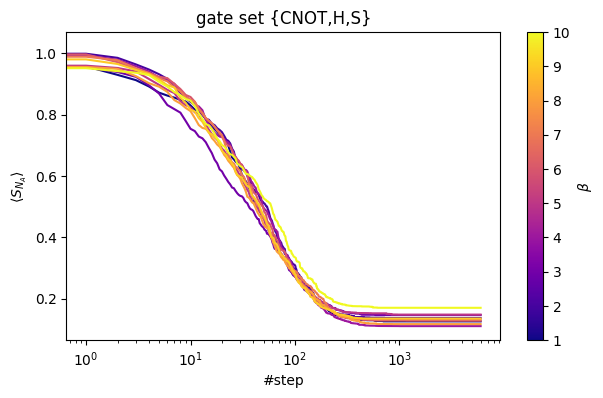

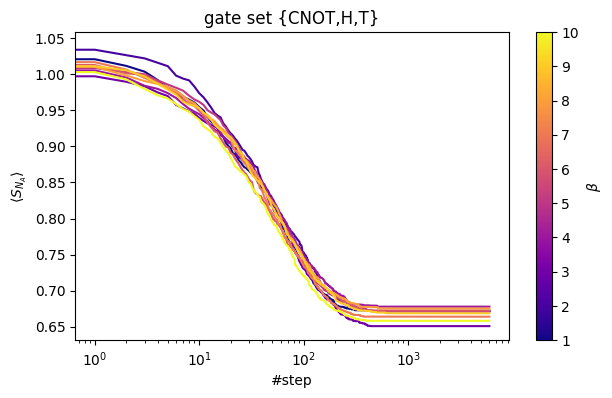

In [31]:
beta_plot(beta_data,fname="_CNOT",savefig=True)

# Effect of system size on thermalization

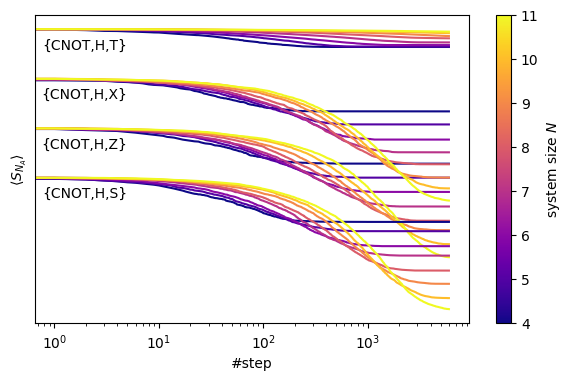

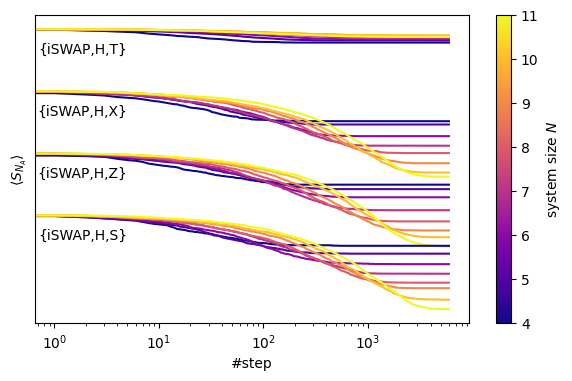

In [32]:
therm_speed_plot(therm_data_CNOT,fname="_CNOT",savefig=True)
therm_speed_plot(therm_data_iSWAP,fname="_iSWAP",savefig=True)

# Level spacing statistic

/var/folders/xd/w75n_hkn7yxdt_5lc6n52n0m0000gn/T/ipykernel_93204/4007842466.py:193: OptimizeWarning: Covariance of the parameters could not be estimated
  non_coolable_popt,pcov = sci.optimize.curve_fit(poisson,non_coolable_bins,non_coolable_counts)
/var/folders/xd/w75n_hkn7yxdt_5lc6n52n0m0000gn/T/ipykernel_93204/4007842466.py:193: OptimizeWarning: Covariance of the parameters could not be estimated
  non_coolable_popt,pcov = sci.optimize.curve_fit(poisson,non_coolable_bins,non_coolable_counts)


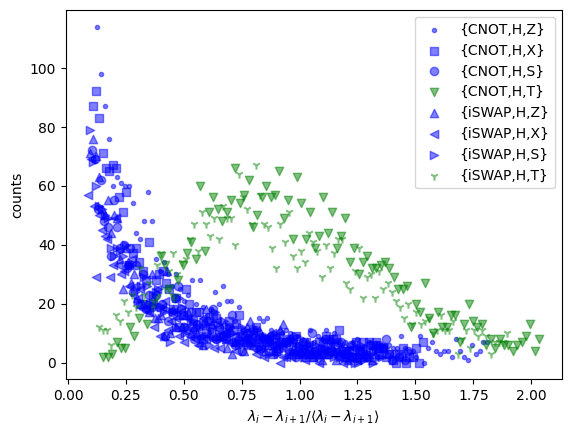

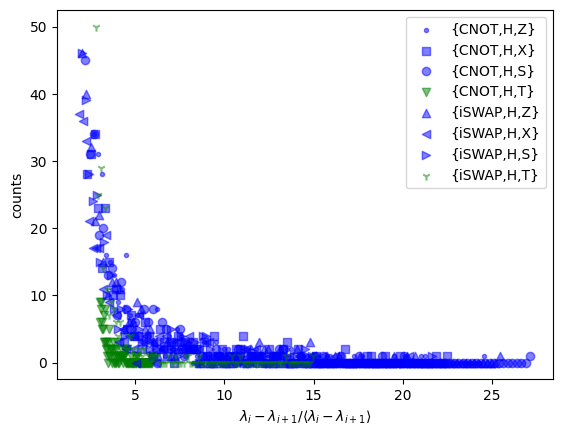

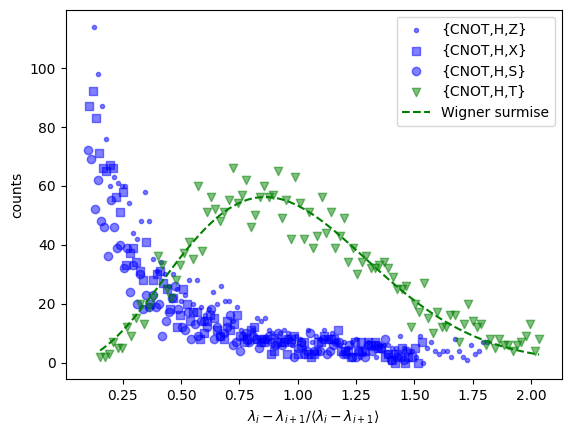

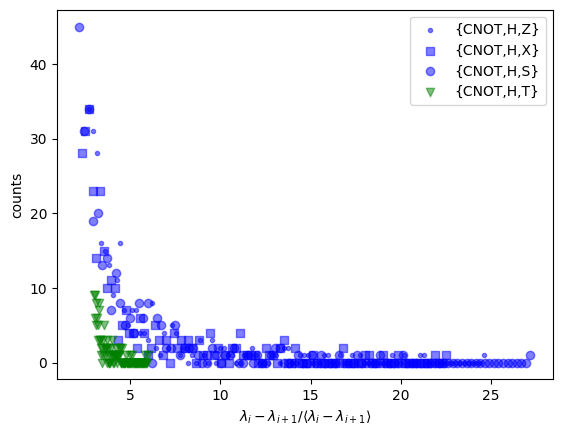

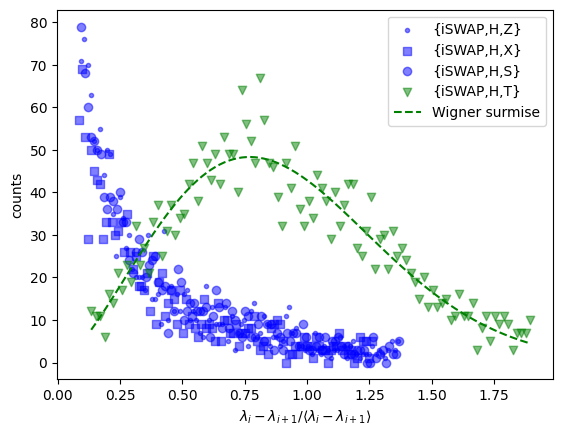

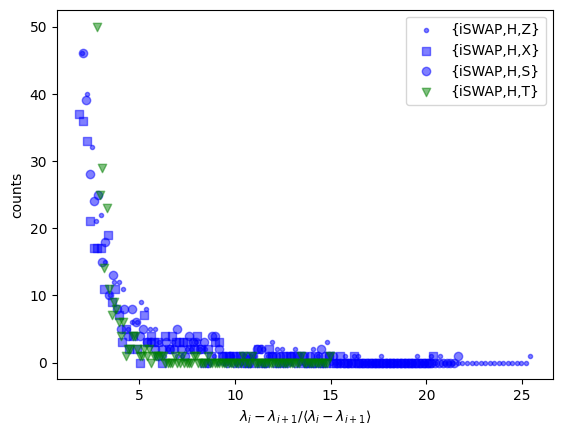

In [47]:
nWires = 11
plot_level_spacing(
    [dataset for dataset in therm_data_CNOT + therm_data_iSWAP if dataset["heating"]["nWires"] == nWires],
    minval=0.0007,
    cutoff=0.015,
    nBins=100,
    fname="_CNOT+iSWAP",
    savefig=True,
)
plot_level_spacing(
    [dataset for dataset in therm_data_CNOT if dataset["heating"]["nWires"] == nWires],
    minval=0.0007,
    cutoff=0.015,
    nBins=100,
    fname="_CNOT",
    fit=True,
    savefig=True,
)
plot_level_spacing(
    [dataset for dataset in therm_data_iSWAP if dataset["heating"]["nWires"] == nWires],
    minval=0.0007,
    cutoff=0.015,
    nBins=100,
    fname="_iSWAP",
    fit=True,
    savefig=True,
)

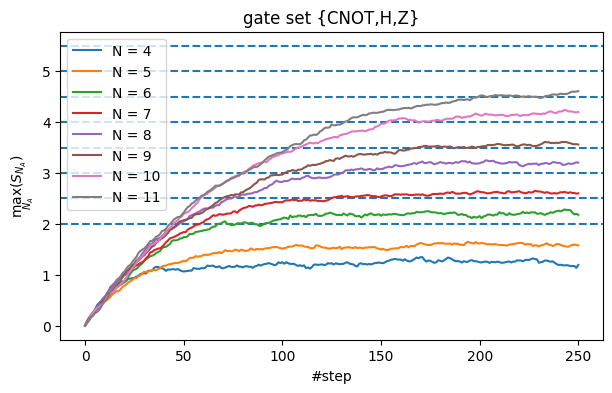

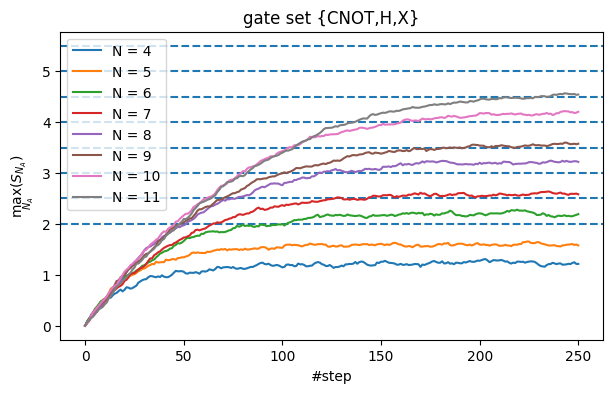

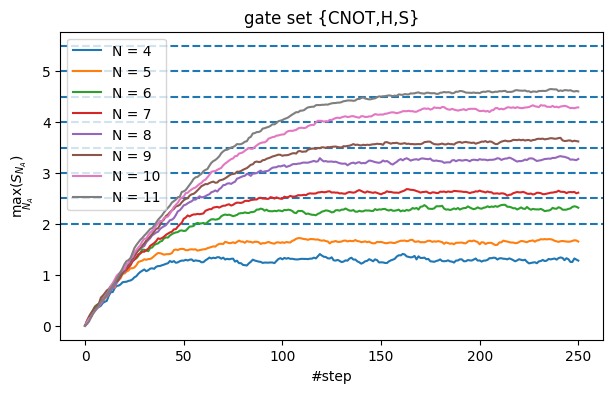

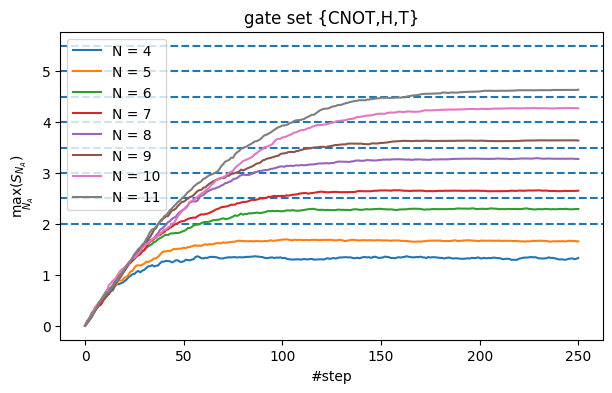

In [34]:
plot_max_heat(therm_data_CNOT)